# 🌟 **Credit Card Fraud Detection**

Welcome to my in-depth credit card fraud detection notebook! 🚀

In this notebook, I embark on a journey to detect fraudulent credit card transactions using logistic regression. My goal is to transform transaction data into accurate fraud predictions, helping identify potential fraudulent activity effectively.

## 👤 **Author Information**

- **Name**: Angelo Traverso
- **Module Code**: PDAN8412
- **Due Date**: 2024/10/14

## 📚 **What You'll Find Here**

1. **Data Preprocessing**: Clean and prepare credit card transaction data to make it suitable for analysis.
2. **Model Building**: Develop and train machine logistic regression models to classify fraudulent and non-fraudulent transactions.
3. **Visualization**: Explore visual representations of the data and model performance.
4. **Testing and Evaluation**: Assess model accuracy, precision, recall, and other metrics to evaluate the effectiveness of fraud detection.

## 🔍 **Objectives**

- **Data Cleaning**: Handle missing values and normalize transaction data for consistency.
- **Fraud Detection**: Build models to distinguish between fraudulent and legitimate transactions.
- **Model Improvements**: Utilize techniques like cross-validation and hyperparameter tuning to improve model performance.

### 🔗 **Dataset Information**

- **Dataset Name**: [Credit Card Fraud Detection Dataset 2023](https://www.kaggle.com/datasets/nelgiriyewithana/credit-card-fraud-detection-dataset-2023)
- **Source**: Kaggle
- **Description**: This dataset contains credit card transactions made by European cardholders in the year 2023. It comprises over 550,000 records, and the data has been anonymized to protect the cardholders' identities. The primary objective of this dataset is to facilitate the development of fraud detection algorithms and models to identify potentially fraudulent transactions.

---

et's get started by importing the necessary packages for this fraud detection analysis. Below, you'll find the detailed steps to clean and prepare the data for the fraud detection model. Happy detecting! 🎉 🎉



In [65]:
import pandas as pd # Importing pandas for data manipulation
import matplotlib.pyplot as plt # Importing pyplot for visualizations
import seaborn as sns # Importing Seaborn for even more visualization techniques
import numpy as np # Importing numpy for arithmetic operations
from pyspark.sql import SparkSession # Importing SparkSession to create a Spark session for distributed data processing
from pyspark.sql.functions import when, col # Importing functions to apply conditional expressions and column manipulations in Spark

In [66]:
# Initializing a SparkSession named 'YelpReviews'
# The SparkSession is the entry point to programming with Spark as it allows you to create DataFrames, register DataFrames as tables, execute SQL queries, 
# and read data from various sources.
# (Chanda, 2024) https://medium.com/@rakeshchanda/spark-out-of-memory-issue-memory-tuning-and-management-in-pyspark-802b757b562f
sparksesh = SparkSession.builder.appName("creditcard_fraud").config("spark.driver.memory", "8g").config("spark.executor.memory", "8g").getOrCreate()

In [67]:
# Retrieving the memory status size of all executors in the Spark application
# In this case, the output count of all executors is 1
sparksesh._jsc.sc().getExecutorMemoryStatus().size()

1

In [68]:
# Reading from the json file provided by 'Yelp' and storing it all in a spark dataframe.
spark_df = sparksesh.read.option("header", True).format("csv").load("creditcard_2023.csv")

In [69]:
# Printing the schema of the dataframe, it outputs the structure of the DataFrame
# It outputs: columns names, data types, and feature elements
spark_df.printSchema()

# Displaying the first five entries from the dataframe
# This is done to ensure the data was read correctly, and all data is in its desired format
spark_df.show(5)

root
 |-- id: string (nullable = true)
 |-- V1: string (nullable = true)
 |-- V2: string (nullable = true)
 |-- V3: string (nullable = true)
 |-- V4: string (nullable = true)
 |-- V5: string (nullable = true)
 |-- V6: string (nullable = true)
 |-- V7: string (nullable = true)
 |-- V8: string (nullable = true)
 |-- V9: string (nullable = true)
 |-- V10: string (nullable = true)
 |-- V11: string (nullable = true)
 |-- V12: string (nullable = true)
 |-- V13: string (nullable = true)
 |-- V14: string (nullable = true)
 |-- V15: string (nullable = true)
 |-- V16: string (nullable = true)
 |-- V17: string (nullable = true)
 |-- V18: string (nullable = true)
 |-- V19: string (nullable = true)
 |-- V20: string (nullable = true)
 |-- V21: string (nullable = true)
 |-- V22: string (nullable = true)
 |-- V23: string (nullable = true)
 |-- V24: string (nullable = true)
 |-- V25: string (nullable = true)
 |-- V26: string (nullable = true)
 |-- V27: string (nullable = true)
 |-- V28: string (nullabl

In [70]:
# Converting the spark data frame into a pandas dataframe
df = spark_df.toPandas()

In [71]:
# Making sure that all of the features are still in their correct format, which in this case its not
# All of the transactions (V1-V28) and 'Amount' should be float64's with 'Class' being int64 as it contains 0 or 1 based on whether or not the feature is fraud
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568630 entries, 0 to 568629
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      568630 non-null  object
 1   V1      568630 non-null  object
 2   V2      568630 non-null  object
 3   V3      568630 non-null  object
 4   V4      568630 non-null  object
 5   V5      568630 non-null  object
 6   V6      568630 non-null  object
 7   V7      568630 non-null  object
 8   V8      568630 non-null  object
 9   V9      568630 non-null  object
 10  V10     568630 non-null  object
 11  V11     568630 non-null  object
 12  V12     568630 non-null  object
 13  V13     568630 non-null  object
 14  V14     568630 non-null  object
 15  V15     568630 non-null  object
 16  V16     568630 non-null  object
 17  V17     568630 non-null  object
 18  V18     568630 non-null  object
 19  V19     568630 non-null  object
 20  V20     568630 non-null  object
 21  V21     568630 non-null  object
 

In [72]:
# This function is used to loop through each column, and change their types based on what they should be
# This step was nesseccory as when spark read the csv file, it interpreted each feature as an object, and not a float64/int64
def convert_column_types(df):
    # Looping through 'V1' to 'V28' and convert them to float64
    for i in range(1, 29):
        # Defining the name of each column with an itterator
        column_name = f'V{i}'
        # If the column name is found, then the feature is transformed to its numeric significant type
        if column_name in df.columns:
            df[column_name] = pd.to_numeric(df[column_name], errors='coerce')

    # Strictly converting 'Amount' to float64
    if 'Amount' in df.columns:
        # Performing conversion on the dataframe feature Amount
        df['Amount'] = pd.to_numeric(df['Amount'], errors='coerce')
    
    # Converting 'Class' to int64 as it hold either 0 or 1 (Should not be an object)
    if 'Class' in df.columns:
        # Performing conversion on the dataframe feature Class
        df['Class'] = df['Class'].astype('int64')

    # Converting 'id' to int64
    if 'id' in df.columns:
        # Performing conversion on the dataframe feature id
        df['id'] = df['id'].astype('int64')
    
    # Returning the modified dataframe
    return df

In [73]:
# Converting the column types to float64 and int64's
df = convert_column_types(df)

# Determining the index dtype and columns, non-null values and memory usage
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568630 entries, 0 to 568629
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      568630 non-null  int64  
 1   V1      568630 non-null  float64
 2   V2      568630 non-null  float64
 3   V3      568630 non-null  float64
 4   V4      568630 non-null  float64
 5   V5      568630 non-null  float64
 6   V6      568630 non-null  float64
 7   V7      568630 non-null  float64
 8   V8      568630 non-null  float64
 9   V9      568630 non-null  float64
 10  V10     568630 non-null  float64
 11  V11     568630 non-null  float64
 12  V12     568630 non-null  float64
 13  V13     568630 non-null  float64
 14  V14     568630 non-null  float64
 15  V15     568630 non-null  float64
 16  V16     568630 non-null  float64
 17  V17     568630 non-null  float64
 18  V18     568630 non-null  float64
 19  V19     568630 non-null  float64
 20  V20     568630 non-null  float64
 21  V21     56

In [74]:
# Using describe to find the basic statistical features of the dataset
df.describe()

,id,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,568630.000000,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,...,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,568630.000000,568630.0
mean,284314.500000,-5.638058e-17,-1.319545e-16,-3.518788e-17,-2.879008e-17,7.997245e-18,-3.958636e-17,-3.198898e-17,2.109273e-17,3.998623e-17,...,4.758361e-17,3.948640e-18,6.194741e-18,-2.799036e-18,-3.178905e-17,-7.497417e-18,-3.598760e-17,2.609101e-17,12041.957635,0.5
std,164149.486122,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,6919.644449,0.5
min,0.000000,-3.495584e+00,-4.996657e+01,-3.183760e+00,-4.951222e+00,-9.952786e+00,-2.111111e+01,-4.351839e+00,-1.075634e+01,-3.751919e+00,...,-1.938252e+01,-7.734798e+00,-3.029545e+01,-4.067968e+00,-1.361263e+01,-8.226969e+00,-1.049863e+01,-3.903524e+01,50.010000,0.0
25%,142157.250000,-5.652859e-01,-4.866777e-01,-6.492987e-01,-6.560203e-01,-2.934955e-01,-4.458712e-01,-2.835329e-01,-1.922572e-01,-5.687446e-01,...,-1.664408e-01,-4.904892e-01,-2.376289e-01,-6.515801e-01,-5.541485e-01,-6.318948e-01,-3.049607e-01,-2.318783e-01,6054.892500,0.0
50%,284314.500000,-9.363846e-02,-1.358939e-01,3.528579e-04,-7.376152e-02,8.108788e-02,7.871758e-02,2.333659e-01,-1.145242e-01,9.252647e-02,...,-3.743065e-02,-2.732881e-02,-5.968903e-02,1.590123e-02,-8.193162e-03,-1.189208e-02,-1.729111e-01,-1.392973e-02,12030.150000,0.5
75%,426471.750000,8.326582e-01,3.435552e-01,6.285380e-01,7.070047e-01,4.397368e-01,4.977881e-01,5.259548e-01,4.729905e-02,5.592621e-01,...,1.479787e-01,4.638817e-01,1.557153e-01,7.007374e-01,5.500147e-01,6.728879e-01,3.340230e-01,4.095903e-01,18036.330000,1.0
max,568629.000000,2.229046e+00,4.361865e+00,1.412583e+01,3.201536e+00,4.271689e+01,2.616840e+01,2.178730e+02,5.958040e+00,2.027006e+01,...,8.087080e+00,1.263251e+01,3.170763e+01,1.296564e+01,1.462151e+01,5.623285e+00,1.132311e+02,7.725594e+01,24039.930000,1.0


In [75]:
# Importing the StandardScaler class from sklearn's preprocessing module
from sklearn.preprocessing import StandardScaler

# Creating an instance of StandardScaler to scale data (standardize features by removing the mean and scaling to unit variance)
std_scaler = StandardScaler()

# Applying the StandardScaler to the 'Amount' column of the dataframe.
# This scales the Amount values to have a mean of 0 and a syandard deviation of 1
df['Amount'] = std_scaler.fit_transform(pd.DataFrame(df['Amount']))

In [76]:
# Finding the first five entries in the dataset to view the alterations made when Scaling the Amount feature
df.head()

,id,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-0.260648,-0.469648,2.496266,-0.083724,0.129681,0.732898,0.519014,-0.130006,0.727159,...,-0.110552,0.217606,-0.134794,0.165959,0.126280,-0.434824,-0.081230,-0.151045,0.858447,0
1,1,0.985100,-0.356045,0.558056,-0.429654,0.277140,0.428605,0.406466,-0.133118,0.347452,...,-0.194936,-0.605761,0.079469,-0.577395,0.190090,0.296503,-0.248052,-0.064512,-0.796369,0
2,2,-0.260272,-0.949385,1.728538,-0.457986,0.074062,1.419481,0.743511,-0.095576,-0.261297,...,-0.005020,0.702906,0.945045,-1.154666,-0.605564,-0.312895,-0.300258,-0.244718,-1.377011,0
3,3,-0.152152,-0.508959,1.746840,-1.090178,0.249486,1.143312,0.518269,-0.065130,-0.205698,...,-0.146927,-0.038212,-0.214048,-1.893131,1.003963,-0.515950,-0.165316,0.048424,-0.962119,0
4,4,-0.206820,-0.165280,1.527053,-0.448293,0.106125,0.530549,0.658849,-0.212660,1.049921,...,-0.106984,0.729727,-0.161666,0.312561,-0.414116,1.071126,0.023712,0.419117,0.323285,0


In [77]:
# Ensuring the standard deviation has been updated and is now in line with the other features and their STD
df.describe()

,id,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,568630.000000,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,...,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,568630.0
mean,284314.500000,-5.638058e-17,-1.319545e-16,-3.518788e-17,-2.879008e-17,7.997245e-18,-3.958636e-17,-3.198898e-17,2.109273e-17,3.998623e-17,...,4.758361e-17,3.948640e-18,6.194741e-18,-2.799036e-18,-3.178905e-17,-7.497417e-18,-3.598760e-17,2.609101e-17,-4.021240e-16,0.5
std,164149.486122,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,0.5
min,0.000000,-3.495584e+00,-4.996657e+01,-3.183760e+00,-4.951222e+00,-9.952786e+00,-2.111111e+01,-4.351839e+00,-1.075634e+01,-3.751919e+00,...,-1.938252e+01,-7.734798e+00,-3.029545e+01,-4.067968e+00,-1.361263e+01,-8.226969e+00,-1.049863e+01,-3.903524e+01,-1.733031e+00,0.0
25%,142157.250000,-5.652859e-01,-4.866777e-01,-6.492987e-01,-6.560203e-01,-2.934955e-01,-4.458712e-01,-2.835329e-01,-1.922572e-01,-5.687446e-01,...,-1.664408e-01,-4.904892e-01,-2.376289e-01,-6.515801e-01,-5.541485e-01,-6.318948e-01,-3.049607e-01,-2.318783e-01,-8.652280e-01,0.0
50%,284314.500000,-9.363846e-02,-1.358939e-01,3.528579e-04,-7.376152e-02,8.108788e-02,7.871758e-02,2.333659e-01,-1.145242e-01,9.252647e-02,...,-3.743065e-02,-2.732881e-02,-5.968903e-02,1.590123e-02,-8.193162e-03,-1.189208e-02,-1.729111e-01,-1.392973e-02,-1.706395e-03,0.5
75%,426471.750000,8.326582e-01,3.435552e-01,6.285380e-01,7.070047e-01,4.397368e-01,4.977881e-01,5.259548e-01,4.729905e-02,5.592621e-01,...,1.479787e-01,4.638817e-01,1.557153e-01,7.007374e-01,5.500147e-01,6.728879e-01,3.340230e-01,4.095903e-01,8.662841e-01,1.0
max,568629.000000,2.229046e+00,4.361865e+00,1.412583e+01,3.201536e+00,4.271689e+01,2.616840e+01,2.178730e+02,5.958040e+00,2.027006e+01,...,8.087080e+00,1.263251e+01,3.170763e+01,1.296564e+01,1.462151e+01,5.623285e+00,1.132311e+02,7.725594e+01,1.733902e+00,1.0


In [78]:
# Ensuring that there are no nulls in the dataset
df.isnull().sum().sum()

0

In [79]:
# Determining whether or not there are duplicates within the dataset
df.duplicated().any()

False

In [80]:
# Dropping potential duplicates
df = df.drop_duplicates()

In [81]:
# Finding the shape of the dataset
df.shape

(568630, 31)

In [82]:
# Dropping the 'id' column as it is not needed for this analysis
df.drop('id', axis='columns',inplace=True)
# Showing the top 5 entries to ensure 'id' was successflly dropped
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-0.260648,-0.469648,2.496266,-0.083724,0.129681,0.732898,0.519014,-0.130006,0.727159,0.637735,...,-0.110552,0.217606,-0.134794,0.165959,0.126280,-0.434824,-0.081230,-0.151045,0.858447,0
1,0.985100,-0.356045,0.558056,-0.429654,0.277140,0.428605,0.406466,-0.133118,0.347452,0.529808,...,-0.194936,-0.605761,0.079469,-0.577395,0.190090,0.296503,-0.248052,-0.064512,-0.796369,0
2,-0.260272,-0.949385,1.728538,-0.457986,0.074062,1.419481,0.743511,-0.095576,-0.261297,0.690708,...,-0.005020,0.702906,0.945045,-1.154666,-0.605564,-0.312895,-0.300258,-0.244718,-1.377011,0
3,-0.152152,-0.508959,1.746840,-1.090178,0.249486,1.143312,0.518269,-0.065130,-0.205698,0.575231,...,-0.146927,-0.038212,-0.214048,-1.893131,1.003963,-0.515950,-0.165316,0.048424,-0.962119,0
4,-0.206820,-0.165280,1.527053,-0.448293,0.106125,0.530549,0.658849,-0.212660,1.049921,0.968046,...,-0.106984,0.729727,-0.161666,0.312561,-0.414116,1.071126,0.023712,0.419117,0.323285,0


In [83]:
# Setting the y variable for processing
# The y variable holds the class that the transaction belongs to, either 0 (Not fraud) or 1 (Fraud) 
y = df['Class']
# Setting the X variable to all the features, besides 'Class'
X = df.drop('Class', axis=1)

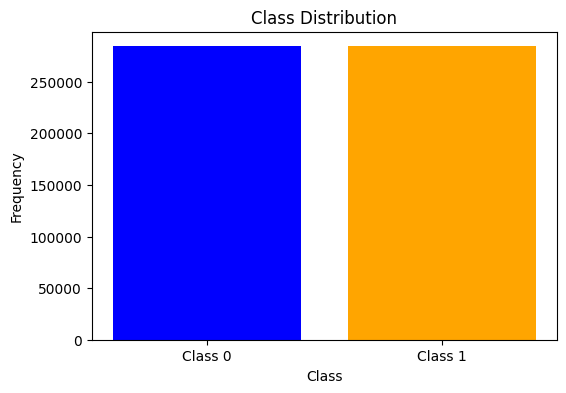

In [84]:
# Variable to hold the count of each class, either 0 or 1
class_counts = df['Class'].value_counts()

# Creating a figure with a size of (6, 4)
plt.figure(figsize=(6,4))
# Setting the plot to a bar graph, using the index as X and the actual values as Y
plt.bar(class_counts.index, class_counts.values, color=['blue', 'orange'])
# Setting the X label text
plt.xlabel('Class')
# Setting the Y label text
plt.ylabel('Frequency')
# Setting the title of the plot
plt.title('Class Distribution')
plt.xticks([0, 1], ['Class 0', 'Class 1'])
plt.show()

# **Custom Logistic Regression Model**
---

In [85]:
# Importing pickle to save and load data
import pickle
# Importing train_test_split to split the data into X and y training and testing sets
from sklearn.model_selection import train_test_split

# Splitting the data into X and y test and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=110)

# Saving the split data using pickles
with open('X_train.pkl', 'wb') as f:
    pickle.dump(X_train, f)
with open('X_test.pkl', 'wb') as f:
    pickle.dump(X_test, f)
with open('y_train.pkl', 'wb') as f:
    pickle.dump(y_train, f)
with open('y_test.pkl', 'wb') as f:
    pickle.dump(y_test, f)

In [86]:
# Using pickles to load the data, saved earlier. Each load is saved into a new variable
with open('X_train.pkl', 'rb') as f:
    X_train = pickle.load(f)
with open('X_test.pkl', 'rb') as f:
    X_test = pickle.load(f)
with open('y_train.pkl', 'rb') as f:
    y_train = pickle.load(f)
with open('y_test.pkl', 'rb') as f:
    y_test = pickle.load(f)

In [87]:
# This class was created as a custom logistic regression model, with all/most of the functionality that any other Logisitc Regression model has
# (Koushik, 2023) https://medium.com/@koushikkushal95/logistic-regression-from-scratch-dfb8527a4226
# (Koushik, 2023) was used for the foundation of this model, the rest was ammended to suit my use case.
class LogisticRegression:
    def __init__(self, learning_rate=0.001, n_iters=1500):
        # Setting the learning rate
        self.lr = learning_rate
        # Setting the number of itterations
        self.n_iters = n_iters
        # Initializing the weights as none for now
        self.weights = None
        # Initializing the bias to none for now as well
        self.bias = None
        # Storing the loss values for each itteration
        self.losses = []
         
    # Sigmoid activation function
    def _sigmoid(self, x):
        # Applying the sigmoid function
        return 1 / (1 + np.exp(-x))

    # Binary cross-entropy loss function
    def binary_crossentropy_loss(self, y_true, y_pred):
        # Using a small value to avoid log(0)
        epsilon = 1e-9
        # Calculating the first part of binary cross-entropy
        y1 = y_true * np.log(y_pred + epsilon)
        # Calculating second part of binary cross-entropy
        y2 = (1-y_true) * np.log(1 - y_pred + epsilon)
        # Returning the negative mean of the combined loss
        return -np.mean(y1 + y2)

    # Feed-forward pass (computing predictions) function
    def feed_forward(self,X):
        # Computings the linear combination (z = Xw + b)
        z = np.dot(X, self.weights) + self.bias
        # Applying sigmoid to z to get probabilities
        A = self._sigmoid(z)
        # Returning the predicted probabilities
        return A

    def fit(self, X, y):
        # Getting the number of samples and features from the data
        n_samples, n_features = X.shape
        # Initialize weights as zeros
        self.weights = np.zeros(n_features)
        # Initialize bias as zero
        self.bias = 0

        # Performing gradient descent for n_iters iterations
        for _ in range(self.n_iters):
            # Getting the predictions using the current weights and bias
            A = self.feed_forward(X)
            # Calculating the loss
            loss = self.binary_crossentropy_loss(y, A)
            # Appending the loss to the list for tracking
            self.losses.append(loss)

            # Computing the gradient of loss w.r.t predictions
            dz = A - y
            # Computing the gradient of weights
            dw = (1 / n_samples) * np.dot(X.T, dz)
            # Computing the gradient of bias
            db = (1 / n_samples) * np.sum(dz)
            # Updating weights using the gradients and learning rate
            self.weights -= self.lr * dw
             # Updating bias using the gradient and learning rate
            self.bias -= self.lr * db

            # Printing each iteration (Similar to an epoch) at every 100th itteration
            if _ % 100 == 0:
                print(f"Iteration {_}: Loss: {loss}")

    # Predicting class labels for input data        
    def predict(self, X):
        # Setting the decision threshold to 0.5
        threshold = .5
        # Determining the linear combination of inputs
        y_hat = np.dot(X, self.weights) + self.bias
        # Applying the sigmoid function to get probabilities
        y_predicted = self._sigmoid(y_hat)
        # Converting probabilities to class labels based on threshold
        y_predicted_cls = [1 if i > threshold else 0 for i in y_predicted]
        
        # Returning the predicted class labels
        return np.array(y_predicted_cls)

In [88]:
# Importing metrics for evaluation
from sklearn import metrics
# Importing accuracy score function 
from sklearn.metrics import accuracy_score

# Initializing the logistic regression model with specific learning rate and iterations
regressor = LogisticRegression(learning_rate=0.0001, n_iters=1500)
# Fitting the model to the training data
regressor.fit(X_train, y_train)
# Making prediction on the training data and storing it
y_train_pred  = regressor.predict(X_train)
# Making predictions on the test data and storing it
predictions = regressor.predict(X_test)


# Calculating confusion matrix
cm = metrics.confusion_matrix(np.asarray(y_test), np.asarray(predictions))
# Calculating training accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
# Calculating testing accuracy
accuracy = metrics.accuracy_score(np.asarray(y_test), np.asarray(predictions))
# Calculating recall (Sensitivity)
sens = metrics.recall_score(np.asarray(y_test), np.asarray(predictions))
# Calculating the precision
precision = metrics.precision_score(np.asarray(y_test), np.asarray(predictions))
# Calculating the f1-score
f_score = metrics.f1_score(np.asarray(y_test), np.asarray(predictions))

# Printing the results of the model
print('Model Performance Report\n--------------------------------')
# Printing the training accuracy
print("Training accuracy: {0:.3f}".format(train_accuracy))
# Printing the test accuracy
print("Test accuracy: {0:.3f}".format(accuracy))
# Printing the confusion matrix
print("Confusion Matrix:\n", cm)
# Printing the Recall value
print("Sensitivity (Recall): {0:.3f}".format(sens))
# Printing the Precision value
print("Precision: {0:.3f}".format(precision))
#Printing the F-Score Calculated
print("F-score: {0:.3f}".format(f_score))

Iteration 0: Loss: 0.6931471785599461
Iteration 100: Loss: 0.6795869251989326
Iteration 200: Loss: 0.6666458365351687
Iteration 300: Loss: 0.6542931931028076
Iteration 400: Loss: 0.6424990929139468
Iteration 500: Loss: 0.6312345882600463
Iteration 600: Loss: 0.6204717899272846
Iteration 700: Loss: 0.6101839418820688
Iteration 800: Loss: 0.60034546989933
Iteration 900: Loss: 0.5909320077516587
Iteration 1000: Loss: 0.5819204045143905
Iteration 1100: Loss: 0.5732887163361358
Iteration 1200: Loss: 0.5650161857320652
Iteration 1300: Loss: 0.5570832111213415
Iteration 1400: Loss: 0.5494713089806418
Model Performance Report
--------------------------------
Training accuracy: 0.906
Test accuracy: 0.905
Confusion Matrix:
 [[85001    24]
 [16213 69351]]
Sensitivity (Recall): 0.811
Precision: 1.000
F-score: 0.895


In [89]:
# Setting a lower threshold
threshold = 0.1

# Predicting based on the new threshold
y_predicted_cls = [1 if i > threshold else 0 for i in predictions]

# Finding the new confusion matrix
cm = metrics.confusion_matrix(y_test, y_predicted_cls)
# Determining the accuracy of the predictions
accuracy = metrics.accuracy_score(y_test, y_predicted_cls)

# Displaying the new metrics
print("Confusion Matrix:", cm)
print("Accuracy:", accuracy)

Confusion Matrix: [[85001    24]
 [16213 69351]]
Accuracy: 0.9048180128847698


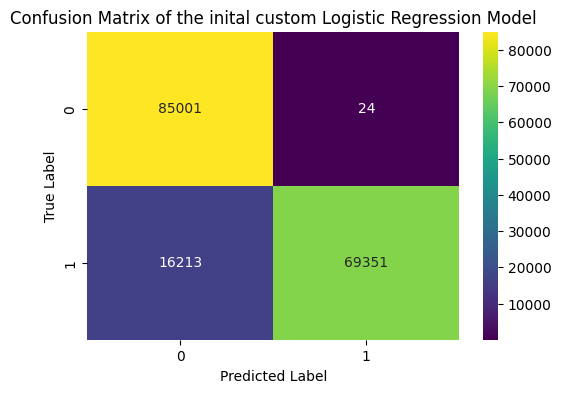

In [90]:
#conf_matrix_initial = metrics.confusion_matrix(y_test, y_predicted_cls)

# Plotting the confusion matrix
plt.figure(figsize=(6,4))
# Generating a heatmap fo rthe confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis')

# Adding labels and title for the confusion matrix plot
plt.title('Confusion Matrix of the inital custom Logistic Regression Model')
# Setting the y label text
plt.ylabel('True Label')
# Setting the x label text
plt.xlabel('Predicted Label')

# Showing the plot
plt.show()

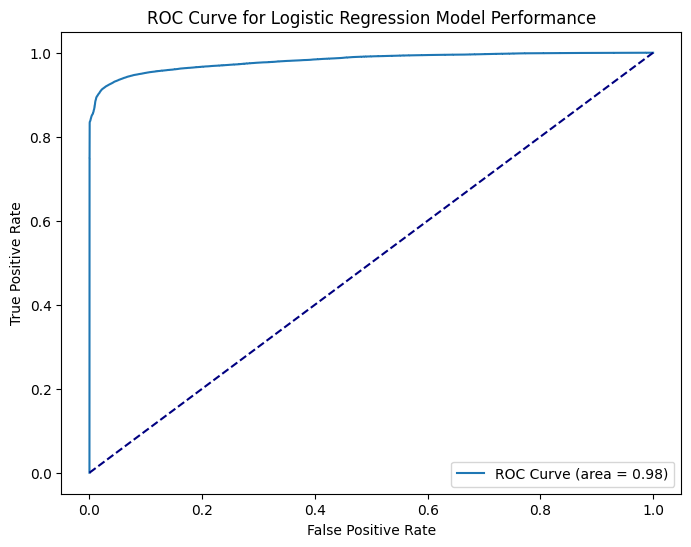

In [91]:
# (Brownlee, 2023)
# Jason Brownlee (2018). How to Use ROC Curves and Precision-Recall Curves for Classification in Python. [online] Machine Learning Mastery. Available at: https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/ [Accessed 14 Oct. 2024].
# Importing functions to compute ROC and AUC
from sklearn.metrics import roc_curve, auc

# Using the feed_forward method to get predicted probabilities
y_probs = regressor.feed_forward(X_test)

# Computing ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve]
# Setting the figure size
plt.figure(figsize=(8, 6))
# Plotting the ROC Curve with an AUC label
plt.plot(fpr, tpr, label=f'ROC Curve (area = {roc_auc:.2f})')
# Diagonal line for reference
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
# Setting Label text for x-axis
plt.xlabel('False Positive Rate')
# Setting Label text for y-axis
plt.ylabel('True Positive Rate')
# Setting the title text
plt.title('ROC Curve for Logistic Regression Model Performance')
# Specifying a legend position
plt.legend(loc="lower right")
# Showing the graph
plt.show()

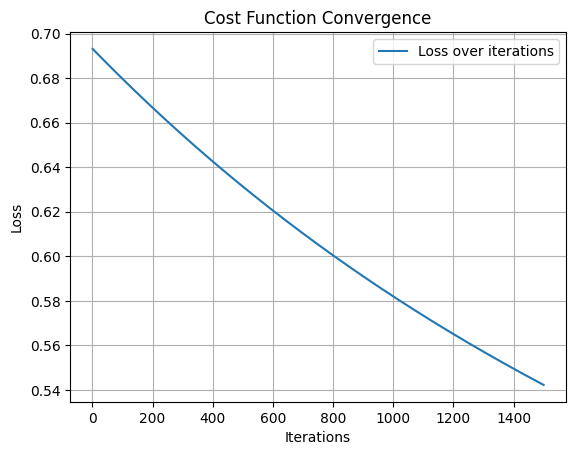

In [92]:
#(Ishwarya, 2024)
# Ishwarya S (2024). Gradient Descent in Machine Learning: A Deep Dive - Ishwarya S - Medium. [online] Medium. Available at: https://ishwaryasriraman.medium.com/gradient-descent-in-machine-learning-a-deep-dive-26cd1df53835 [Accessed 14 Oct. 2024].
# Plotting the loss values over the iterations
plt.plot(range(1, len(regressor.losses) + 1), regressor.losses, label="Loss over iterations")
# Setting the label text for x-axis
plt.xlabel('Iterations')
# Setting the label text for y-axis
plt.ylabel('Loss')
# Setting the title text for the graph
plt.title('Cost Function Convergence')
# Adding a legend
plt.legend()
# Showing the grid within the graph
plt.grid(True)
# Shwowing the graph
plt.show()

# **Improved Custom Logistic Regression Model**
---

In [93]:
# This class was created as a custom logistic regression model, with all/most of the functionality that any other Logistic Regression model has
# (Koushik, 2023) https://medium.com/@koushikkushal95/logistic-regression-from-scratch-dfb8527a4226
# (Koushik, 2023) was used for the foundation of this model, the rest was ammended to suit my use case.
class LogisticRegressionWithL2:
    def __init__(self, learning_rate=0.001, n_iters=1000, regularization=None, reg_lambda=0.01):
        # Setting the learning rate
        self.lr = learning_rate
        # Setting the number of itterations
        self.n_iters = n_iters
        # Setting the regularization
        self.regularization = regularization
        # Setting the reg_lambda
        self.reg_lambda = reg_lambda
        # Initializing the weights as none for now
        self.weights = None
         # Initializing the bias to none for now as well
        self.bias = None
         # Storing the loss values for each itteration
        self.losses = []
         
    # Sigmoid activation function
    def _sigmoid(self, x):
         # Applying the sigmoid function
        return 1 / (1 + np.exp(-x))

    # Binary cross-entropy loss function
    def binary_crossentropy_loss(self, y_true, y_pred):
        # Using a small value to avoid log(0)
        epsilon = 1e-9
        # Calculating the first part of binary cross-entropy
        y1 = y_true * np.log(y_pred + epsilon)
        # Calculating second part of binary cross-entropy
        y2 = (1-y_true) * np.log(1 - y_pred + epsilon)
        # Returning the negative mean of the combined loss
        return -np.mean(y1 + y2)
    
    # L2 regularization term (penalty) to prevent overfitting by shrinking weights
    def l2_penalty(self):
        # L2 penalty term (regularization term), excluding the bias term
        # This term will be added to the loss to penalize large weights
        return (self.reg_lambda / (2 * len(self.weights))) * np.sum(self.weights**2)

    # Feed-forward pass (computing predictions) function
    def feed_forward(self,X):
        # Computing the linear combination (z = Xw + b)
        z = np.dot(X, self.weights) + self.bias
        # Applying sigmoid to z to get probabilities
        A = self._sigmoid(z)
        # Returning the predicted probabilities
        return A

    def fit(self, X, y):
        # Getting the number of samples and features from the data
        n_samples, n_features = X.shape
        # Initialize weights as zeros
        self.weights = np.zeros(n_features)
        # Initialize bias as zero
        self.bias = 0

        # Performing gradient descent for n_iters iterations
        for _ in range(self.n_iters):
            # Getting the predictions using the current weights and bias
            A = self.feed_forward(X)
            # Calculating the loss
            loss = self.binary_crossentropy_loss(y, A)
            # Appending the loss to the list for tracking
            self.losses.append(loss)

            # Computing the gradient of loss w.r.t predictions
            dz = A - y
            # Computing the gradient of weights
            dw = (1 / n_samples) * np.dot(X.T, dz)
            # Computing the gradient of bias
            db = (1 / n_samples) * np.sum(dz)

            # If L2 Regularization is enabled, then L2 regularization is applied
            if self.regularization == 'l2':
                dw += self.reg_lambda * self.weights / n_samples
            
            # Updating weights using the gradients and learning rate
            self.weights -= self.lr * dw
            # Updating bias using the gradient and learning rate
            self.bias -= self.lr * db

            # Printing each iteration (Similar to an epoch).
            if _ % 100 == 0:
                print(f"Iteration {_}: Loss: {loss}")
            
    def predict(self, X):
        # Setting the decision threshold to 0.5
        threshold = .5
        # Determining the linear combination of inputs
        y_hat = np.dot(X, self.weights) + self.bias
        # Applying the sigmoid function to get probabilities
        y_predicted = self._sigmoid(y_hat)
        # Converting probabilities to class labels based on threshold
        y_predicted_cls = [1 if i > threshold else 0 for i in y_predicted]
        # Returning the predicted class labels
        return np.array(y_predicted_cls)
    
    # Getting model parameters (for hyperparameter tuning).
    # This was required in order to make use of grid search or cross validation
    def get_params(self, deep=True):
        return {
            'learning_rate': self.lr,
            'n_iters': self.n_iters,
            'regularization': self.regularization,
            'reg_lambda': self.reg_lambda
        }

    # Setting model parameters (for hyperparameter tuning)
    def set_params(self, **params):
        # Looping over provided parameters
        for key, value in params.items():
            # Setting parameter values
            setattr(self, key, value)
             # Returning self for method chaining
        return self

In [94]:
# Instantiating the custom Logistic Regression model with L2 regularization
regressorwithl2 = LogisticRegressionWithL2(learning_rate=0.002, n_iters=1500, reg_lambda=0.1)
# Fitting the model on the training data (weights are adjusted using gradient descent)
regressorwithl2.fit(X_train, y_train)
# Predicting class labels for the test set using the trained model
predictionsL2 = regressorwithl2.predict(X_test)


# Calculating the confusion matrix to evaluate model performance
cmL2 = metrics.confusion_matrix(np.asarray(y_test), np.asarray(predictionsL2))

# Calculating the training set accuracy
train_accuracy_l2 = accuracy_score(y_train, y_train_pred)
# Calculating the testing set accuracy
accuracyL2 = metrics.accuracy_score(np.asarray(y_test), np.asarray(predictionsL2))
# Calculating the sensitivty (Recall)
sensL2 = metrics.recall_score(np.asarray(y_test), np.asarray(predictionsL2))
# Calculating the precision
precisionL2 = metrics.precision_score(np.asarray(y_test), np.asarray(predictionsL2))
# Calculating the F1-Score
f_scoreL2 = metrics.f1_score(np.asarray(y_test), np.asarray(predictionsL2))

# Printing the results of the model
print('Model Performance Report\n--------------------------------')
print("Train accuracy: {0:.3f}".format(train_accuracy_l2))
print("Test accuracy: {0:.3f}".format(accuracyL2))
print("Confusion Matrix:\n", cmL2)
print("Sensitivity (Recall): {0:.3f}".format(sensL2))
print("Precision: {0:.3f}".format(precisionL2))
print("F-score: {0:.3f}".format(f_scoreL2))

Iteration 0: Loss: 0.6931471785599461
Iteration 100: Loss: 0.5094023648899949
Iteration 200: Loss: 0.4234751515553051
Iteration 300: Loss: 0.37438430207847156
Iteration 400: Loss: 0.3424141535151434
Iteration 500: Loss: 0.31973710250269394
Iteration 600: Loss: 0.3026599500860123
Iteration 700: Loss: 0.2892179484092908
Iteration 800: Loss: 0.278272216610696
Iteration 900: Loss: 0.26911865165843446
Iteration 1000: Loss: 0.2612993484033505
Iteration 1100: Loss: 0.25450396858266455
Iteration 1200: Loss: 0.24851476778611736
Iteration 1300: Loss: 0.24317435037486784
Iteration 1400: Loss: 0.2383659452757265
Model Performance Report
--------------------------------
Train accuracy: 0.906
Test accuracy: 0.917
Confusion Matrix:
 [[84980    45]
 [14173 71391]]
Sensitivity (Recall): 0.834
Precision: 0.999
F-score: 0.909


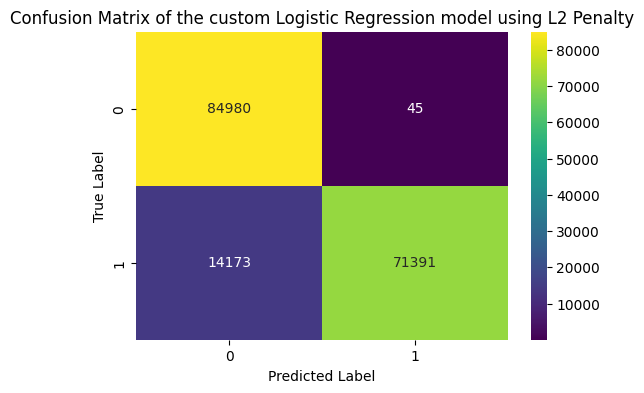

In [95]:
# Plotting the confusion matrix
plt.figure(figsize=(6,4))
# Generating a heatmap fo rthe confusion matrix
sns.heatmap(cmL2, annot=True, fmt='d', cmap='viridis')

# Adding labels and title for the confusion matrix plot
plt.title('Confusion Matrix of the custom Logistic Regression model using L2 Penalty')
# Setting the y label text
plt.ylabel('True Label')
# Setting the x label text
plt.xlabel('Predicted Label')

# Showing the plot
plt.show()

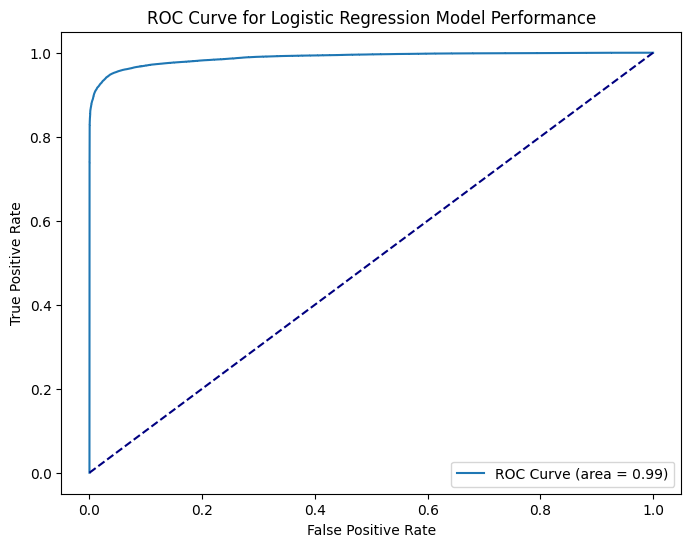

In [96]:
# Using the feed_forward method to get predicted probabilities
y_probsL2 = regressorwithl2.feed_forward(X_test)

# Computing ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test, y_probsL2)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure(figsize=(8, 6))
# Plotting the ROC Curve with an AUC label
plt.plot(fpr, tpr, label=f'ROC Curve (area = {roc_auc:.2f})')
# Diagonal line for reference
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
# Setting Label text for x-axis
plt.xlabel('False Positive Rate')
# Setting Label text for y-axis
plt.ylabel('True Positive Rate')
# Setting the title text
plt.title('ROC Curve for Logistic Regression Model Performance')
# Specifying a legend position
plt.legend(loc="lower right")
# Showing the graph
plt.show()

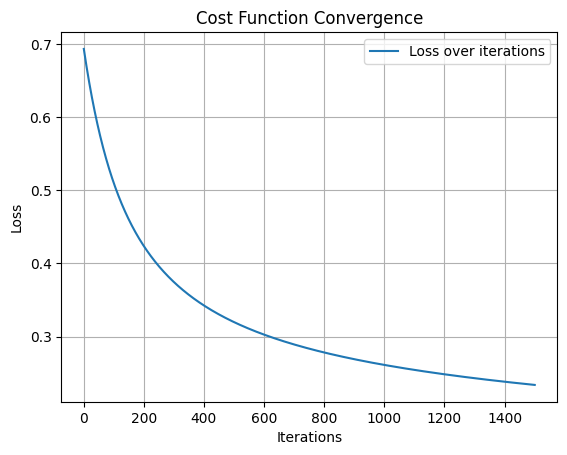

In [97]:
#(Ishwarya, 2024)
# Ishwarya S (2024). Gradient Descent in Machine Learning: A Deep Dive - Ishwarya S - Medium. [online] Medium. Available at: https://ishwaryasriraman.medium.com/gradient-descent-in-machine-learning-a-deep-dive-26cd1df53835 [Accessed 14 Oct. 2024].
# Plotting the loss values over the iterations
plt.plot(range(1, len(regressorwithl2.losses) + 1), regressorwithl2.losses, label="Loss over iterations")
# Setting the label text for x-axis
plt.xlabel('Iterations')
# Setting the label text for y-axis
plt.ylabel('Loss')
# Setting the title text for the graph
plt.title('Cost Function Convergence')
# Adding a legend
plt.legend()
# Showing the grid within the graph
plt.grid(True)
# Shwowing the graph
plt.show()

In [98]:
# Importing the cross validation score function from SKLearn
from sklearn.model_selection import cross_val_score
# Performing Cross-validate on the entire dataset using 5 folds
scores = cross_val_score(regressorwithl2, X, y, cv=5, scoring='accuracy')
# Printing out the average of the cross-validation accuracies 
print(f'Cross-Validation Accuracy: {np.mean(scores)}')

Iteration 0: Loss: 0.6931471785599462
Iteration 100: Loss: 0.5118682349707425
Iteration 200: Loss: 0.43142846313038175
Iteration 300: Loss: 0.38590205461290794
Iteration 400: Loss: 0.3559430854231818
Iteration 500: Loss: 0.33429280020764407
Iteration 600: Loss: 0.3176380189181973
Iteration 700: Loss: 0.3042490866127321
Iteration 800: Loss: 0.2931323611930766
Iteration 900: Loss: 0.2836744364301868
Iteration 1000: Loss: 0.27547457708616285
Iteration 1100: Loss: 0.26825863982580583
Iteration 1200: Loss: 0.26183175398553205
Iteration 1300: Loss: 0.25605084819000196
Iteration 1400: Loss: 0.25080795716147614
Iteration 0: Loss: 0.6931471785599462
Iteration 100: Loss: 0.5143507557131174
Iteration 200: Loss: 0.43419276985270394
Iteration 300: Loss: 0.3885256719386208
Iteration 400: Loss: 0.358343851412568
Iteration 500: Loss: 0.33647228186849354
Iteration 600: Loss: 0.31961943415916866
Iteration 700: Loss: 0.30605920297071265
Iteration 800: Loss: 0.2947960079571029
Iteration 900: Loss: 0.28521

# **SKLearn Logistic Regression Model**
---

In [99]:
# Using pickles to load the data, saved earlier. Each load is saved into a new variable
with open('X_train.pkl', 'rb') as f:
    X_train_sk = pickle.load(f)
with open('X_test.pkl', 'rb') as f:
    X_test_sk = pickle.load(f)
with open('y_train.pkl', 'rb') as f:
    y_train_sk = pickle.load(f)
with open('y_test.pkl', 'rb') as f:
    y_test_sk = pickle.load(f)

In [100]:
# Importing logistic regression from the SKLearn library
from sklearn.linear_model import LogisticRegression
# Importing all metrics associated with sklearn
from sklearn.metrics import *

# Initializing the model using the l2 penalty and 1500 iterations
skLogisticRegression = LogisticRegression(solver='saga', penalty='l2', max_iter=1500)

# Training the model on the newly retrievd data
skLogisticRegression.fit(X_train_sk, y_train_sk)

# Generating predictions for the test data
y_pred_sk = skLogisticRegression.predict(X_test_sk)

# Determining and printing the confusion matrix of the predictions
print("Confusion Matrix:")
print(confusion_matrix(y_test_sk, y_pred_sk))

# Printing the classification report of the model
print("Classification Report:")
print(classification_report(y_test_sk, y_pred_sk))


Confusion Matrix:
[[83291  1734]
 [ 4231 81333]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97     85025
           1       0.98      0.95      0.96     85564

    accuracy                           0.97    170589
   macro avg       0.97      0.97      0.97    170589
weighted avg       0.97      0.97      0.97    170589



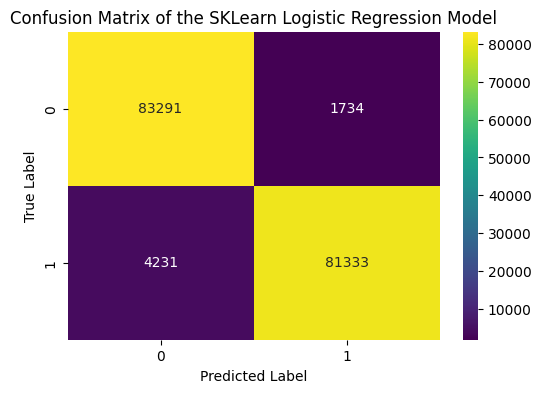

In [101]:
confusion_matrix_sk = confusion_matrix(y_test_sk, y_pred_sk)

# Plotting the confusion matrix
plt.figure(figsize=(6,4))
# Generating a heatmap fo rthe confusion matrix
sns.heatmap(confusion_matrix_sk, annot=True, fmt='d', cmap='viridis')
# Adding labels and title for the confusion matrix plot
plt.title('Confusion Matrix of the SKLearn Logistic Regression Model')
# Setting the y label text
plt.ylabel('True Label')
# Setting the x label text
plt.xlabel('Predicted Label')

# Showing the plot
plt.show()

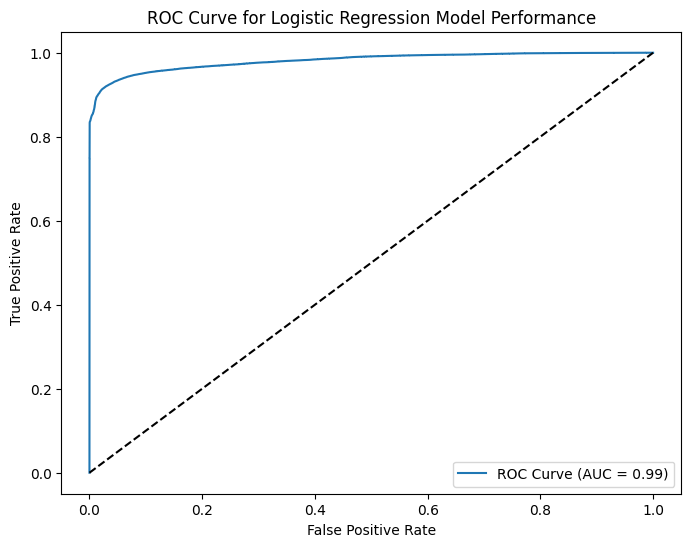

In [102]:
# Getting the probabilities of the positive class
y_probs_sk = skLogisticRegression.predict_proba(X_test_sk)[:, 1]  

# Computing the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
# Plotting the ROC Curve with an AUC label
plt.plot(fpr, tpr, label="ROC Curve (AUC = {:.2f})".format(roc_auc_score(y_test_sk, y_probs_sk)))
# Diagonal line for reference
plt.plot([0, 1], [0, 1], 'k--')
# Setting Label text for x-axis
plt.xlabel('False Positive Rate')
# Setting Label text for y-axis
plt.ylabel('True Positive Rate')
# Setting the title text
plt.title('ROC Curve for Logistic Regression Model Performance')
# Specifying a legend position
plt.legend(loc="lower right")
# Showing the graph
plt.show()

In [103]:
sparksesh.stop

<bound method SparkSession.stop of <pyspark.sql.session.SparkSession object at 0x000001AB013F2A50>>